# Ecommerce Logistics Analysis, Section 3
## 3. Late Delivery Investigation: Who is at fault when the shipment is delivered later than estimated? 

Below is a schema summarizing the relationships between the tables in the database I created in Section 0:
![title](images/schema_rearranged_2.JPG)

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from table_audit import table_audit_function
pd.set_option('display.max_columns', 100)

%matplotlib inline

# Create context manager to handle connection to SQLite database and return dataframe from query
def run_query(q):
    with sqlite3.connect('data/ecommerce.db') as conn:
        return pd.read_sql_query(q,conn)
    
# Create manager to handle queries that don't return tables (ie commands, not queries) like for creating views.
# Manages connection to database such that the database is only connected when this function is running (same as run_query function)
def run_command(c):
    with sqlite3.connect('data/ecommerce.db') as conn:
        conn.isolation_level=None
        conn.execute(c)

In [2]:
# Going to create view w/ all of the neccessary data joined together into one table:
# Turned this cell from code to markdown b/c I only want to run and create the view once.


c1 = '''
CREATE VIEW orders_delivered_summary AS
    SELECT 
        merged.*,
        c.*,
        g.geolocation_lat c_lat,
        g.geolocation_lng c_lng,
        g.Closest_Urban_City Customer_Urban_City,
        g.Urban_City_Distance Customer_Urban_Distance,
        g.Urban Customer_Urban,
        s.*,
        g2.geolocation_lat s_lat,
        g2.geolocation_lng s_lng,
        g2.Closest_Urban_City Seller_Urban_City,
        g2.Urban_City_Distance Seller_Urban_Distance,
        g2.Urban Seller_Urban,
        p.*,
        CASE
        WHEN CAST(julianday(merged.order_estimated_delivery_date)-julianday(merged.order_delivered_customer_date) as real) < -1 THEN "Late delivery"
        WHEN CAST(julianday(merged.order_estimated_delivery_date)-julianday(merged.order_delivered_customer_date) as real)  >= -1 AND CAST(julianday(order_estimated_delivery_date)-julianday(order_delivered_customer_date) as real) <= 0 THEN "On time"
        WHEN CAST(julianday(merged.order_estimated_delivery_date)-julianday(merged.order_delivered_customer_date) as real)  > 0 THEN "Early delivery"
        END
        AS shipment_outcome
    FROM (
        SELECT 
            om.order_id order_id,
            om.customer_id,
            om.order_status,
            om.order_purchase_timestamp,
            om.order_approved_at,
            om.order_delivered_carrier,
            om.order_delivered_customer_date,
            om.order_estimated_delivery_date,
            SUM(oim.order_item_id) quantity,
            oim.product_id,
            oim.seller_id,
            oim.shipping_limit_date,
            oim.price,
            SUM(oim.price) price_full_quantity,
            oim.freight_value,
            SUM(oim.freight_value) freight_value_full_quantity,
            GROUP_CONCAT(opm.payment_sequential),
            GROUP_CONCAT(opm.payment_type),
            GROUP_CONCAT(opm.payment_installments),
            GROUP_CONCAT(opm.payment_value),
            MAX(opm.payment_sequential),
            SUM(opm.payment_installments),
            SUM(opm.payment_value)
        FROM orders_modified om
        LEFT JOIN order_items_modified oim ON oim.order_id=om.order_id
        LEFT JOIN order_payments_modified opm ON opm.order_id=om.order_id
        GROUP BY om.order_id
        ) as merged
    LEFT JOIN products p ON p.product_id=merged.product_id
    LEFT JOIN customers c ON c.customer_id = merged.customer_id
    LEFT JOIN geolocation_updated g ON g.geolocation_zip_code = c.customer_zip_code_prefix
    LEFT JOIN sellers s ON s.seller_id = merged.seller_id
    LEFT JOIN geolocation_updated g2 ON g2.geolocation_zip_code = s.seller_zip_code_prefix
    WHERE merged.order_status='delivered'
'''
# Commented out the line of code below b/c only need to create the view once.
#run_command(c1)

In [3]:
q1 = '''
SELECT *
FROM orders_delivered_summary
'''

df = run_query(q1)
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier,order_delivered_customer_date,order_estimated_delivery_date,quantity,product_id,seller_id,shipping_limit_date,price,price_full_quantity,freight_value,freight_value_full_quantity,GROUP_CONCAT(opm.payment_sequential),GROUP_CONCAT(opm.payment_type),GROUP_CONCAT(opm.payment_installments),GROUP_CONCAT(opm.payment_value),MAX(opm.payment_sequential),SUM(opm.payment_installments),SUM(opm.payment_value),customer_id:1,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,c_lat,c_lng,Customer_Urban_City,Customer_Urban_Distance,Customer_Urban,seller_id:1,seller_zip_code_prefix,seller_city,seller_state,s_lat,s_lng,Seller_Urban_City,Seller_Urban_Distance,Seller_Urban,product_id:1,product_category_name,product_name_length,product_description_height,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,shipment_outcome
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,58.90,13.29,13.29,1,credit_card,2,72.19,1.0,2.0,72.19,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,Campos Dos Goytacazes,1.222070,1.0,48436dade18ac8b2bce089ec2a041202,27277,volta redonda,SP,-22.498183,-44.123614,Volta Redonda,2.086410,1.0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58,598,4,650,28,9,14,Early delivery
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,239.90,19.93,19.93,1,credit_card,3,259.83,1.0,3.0,259.83,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.212393,-50.941471,Santa Fé Do Sul,0.954019,1.0,dd7ddc04e1b6c2c614352b383efe2d36,3471,sao paulo,SP,-23.566258,-46.518417,São Paulo,3.292157,1.0,e5f2d52b802189ee658865ca93d83a8f,pet_shop,56,239,2,30000,50,30,40,Early delivery
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,199.00,17.87,17.87,1,credit_card,5,216.87,1.0,5.0,216.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.860439,-44.597972,Pará De Minas,0.565696,1.0,5b51032eddd242adc84c38acab88f23d,37564,borda da mata,MG,-22.264094,-46.158564,Pouso Alegre,14.351862,1.0,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,59,695,2,3050,33,13,33,Early delivery
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.99,12.79,12.79,1,credit_card,2,25.78,1.0,2.0,25.78,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.144923,-46.539830,Atibaia,2.201440,1.0,9d7a1d34a5052409006425275ba1c2b4,14403,franca,SP,-20.548228,-47.395897,Franca,0.935914,1.0,7634da152a4610f1595efa32f14722fc,perfumaria,42,480,1,200,16,10,15,Early delivery
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,199.90,18.14,18.14,1,credit_card,3,218.04,1.0,3.0,218.04,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.24900

In [4]:
table_audit_function(df)

There are 1 null values in the field GROUP_CONCAT(opm.payment_sequential)
There are 1 null values in the field GROUP_CONCAT(opm.payment_type)
There are 1 null values in the field GROUP_CONCAT(opm.payment_installments)
There are 1 null values in the field GROUP_CONCAT(opm.payment_value)
There are 1 null values in the field MAX(opm.payment_sequential)
There are 1 null values in the field SUM(opm.payment_installments)
There are 1 null values in the field SUM(opm.payment_value)
There are 255 null values in the field c_lat
There are 255 null values in the field c_lng
There are 255 null values in the field Customer_Urban_City
There are 255 null values in the field Customer_Urban_Distance
There are 255 null values in the field Customer_Urban
There are 209 null values in the field s_lat
There are 209 null values in the field s_lng
There are 209 null values in the field Seller_Urban_City
There are 209 null values in the field Seller_Urban_Distance
There are 209 null values in the field Seller_U

### Payment Approval System

Does the payment system have an effect on how the seller handles the order? 

Does the seller take longer to hand over the order items to their carrier if the payment approval time is longer? <br>
1\. Stacked bar graph (equal size bins): continous payment approval time vs before/after shipping limit<br>
2\. Stacked bar graph (equal spaced bins): continous payment approval time vs before/after shipping limit<br>
3\. Box plot: seller to carrier outcome (2 categories) vs time to approve payment (continuous)<br>
4\. Scatter plot: time to approve payment (continuous) vs time to carrier (continous)

Does the seller delay handing over the order items to their carrier past the shipping limit if the payment ahasn't been approved yet? <br>
5\. Stacked bar graph: payment approved before/after shipping limit (2 categories) vs before/after shipping limit
<br>

Does the payment system have an effect on how the carrier handles the order? 

Does the overall delivery take longer if the payment approval time is longer?<br>
6\. Stacked bar graph (equal size bins): continous payment approval time vs late/ot/early shipment outcome<br>
7\. Stacked bar graph (equal spaced bins): continous payment approval time vs late/ot/early shipment outcome<br>
8\. Box plot: late/ot/early shipment outcome (3 categories) vs time to approve payment (continuous)<br>
9\. Scatter plot: time to approve payment (continuous) vs time to deliver (continous)<br>

Does the carrier delay handing over the shipment to the customer if the payment hasn't been approved yet?<br>
10\. Stacked bar graph: payment approved before/after expected delivery time vs late/ot/early shipment outcome<br>



In [5]:
# For the investigation of the payment approval system, only need to look at a subset of the orders_delivered_summary view.

q2 = '''
SELECT
    order_id,
    order_purchase_timestamp,
    order_approved_at,
    order_delivered_carrier,
    shipping_limit_date,
    order_delivered_customer_date,
    order_estimated_delivery_date,
    CAST(julianday(order_approved_at)-julianday(order_purchase_timestamp) as real)*24 time_to_approve_payment,
    CAST(julianday(order_delivered_carrier)-julianday(order_purchase_timestamp) as real) time_to_carrier,
    CAST(julianday(shipping_limit_date)-julianday(order_purchase_timestamp) as real) seller_to_carrier_limit,
    julianday(order_purchase_timestamp),
    CAST(julianday(shipping_limit_date) - julianday(order_delivered_carrier) as real) seller_to_carrier_days_early,
    CASE
        WHEN order_delivered_carrier > shipping_limit_date THEN "After limit"
        ELSE 'Before limit'
        END
        AS seller_to_carrier_outcome,
    CAST(julianday(order_delivered_customer_date)-julianday(order_purchase_timestamp) as real) time_to_deliver_full,
    shipment_outcome
FROM orders_delivered_summary
'''

df2 = run_query(q2)
df2.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,time_to_approve_payment,time_to_carrier,seller_to_carrier_limit,julianday(order_purchase_timestamp),seller_to_carrier_days_early,seller_to_carrier_outcome,time_to_deliver_full,shipment_outcome
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-19 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,0.775833,6.399468,6.032326,2.458010e+06,-0.367141,After limit,7.614421,Early delivery
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-03 11:05:13,2017-05-12 16:04:24,2017-05-15 00:00:00,0.201944,8.154097,7.008414,2.457870e+06,-1.145683,After limit,16.216181,Early delivery
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-18 14:48:30,2018-01-22 13:19:16,2018-02-05 00:00:00,0.249722,1.918947,4.010405,2.458133e+06,2.091458,Before limit,7.948437,Early delivery
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-15 10:10:18,2018-08-14 13:32:39,2018-08-20 00:00:00,0.161944,2.144039,7.006748,2.458339e+06,4.862708,Before limit,6.147269,Early delivery
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-02-13 13:57:51,2017-03-01 16:42:31,2017-03-17 00:00:00,0.206111,11.825208,9.000000,2.457789e+06,-2.825208,After limit,25.114352,Early delivery


In [6]:
# Number of shipments where the payment is approved AFTER the seller gives the order items to the carrier
num_shipments_payment_after_carrier = len(df2[df2['time_to_approve_payment']>df2['time_to_carrier']])
print('Number of shipments where the payment is approved AFTER the seller gives the order items to the carrier:', num_shipments_payment_after_carrier, '(', round(num_shipments_payment_after_carrier/len(df2)*100,2) ,'%).')

# Number of shipments where the payment is approved AFTER the customer receives the shipment
num_shipments_payment_after_delivered = len(df2[df2['time_to_approve_payment']>df2['time_to_deliver_full']])
print('Number of shipments where the payment is approved AFTER the customer receives the shipment: ', num_shipments_payment_after_delivered, '(',round(num_shipments_payment_after_delivered/len(df2)*100,2) ,'%).')


Number of shipments where the payment is approved AFTER the seller gives the order items to the carrier: 33032 ( 35.41 %).
Number of shipments where the payment is approved AFTER the customer receives the shipment:  24147 ( 25.89 %).


<b>Observations</b>: <br>
It seems that it is pretty common for the shipment process to begin (and complete) before the payment is approved. This may indicate that the time to approve the payment has no impact on the shipment outcome.<br>

<b>Special Note</b> <br>
Note that originally there were 159 records with a negative value for the field 'time_to_carrier'. I am proceeding with the assumption that these values are just an error and that the time to the carrier should actually be 0 b/c the item was already located in the warehouse/storage facility of the logistic partner (which is why it would have a negative before b/c the time of purchase would be after the time the item was given to carrier by the seller).<br> 

In order to proceed with this analysis so that it makes intuitive sense, going to set the date the order is delivered to the carrier to the time when the order was originally purchased. <br>

In order to update all 159 records efficiently, I have written a function in python that creates and runs all 159 SQL update value commands. I have written this function to be flexible enough that it can be used to update the database under a variety of scenarios. This way I can update all 159 records very, very easily instead of manually updating each record. Note that I changed a number of the views to tables so that the update command would work (you can't alter/update a view).

In [7]:
def update_database_automated(command, set_value_list, where_value_list):
    
    for index, value in enumerate(where_value_list):
        command_old = command
        command = command.format(set_value_list[index], where_value_list[index])
        run_command(command)
        print(command)
        command = command_old
        
df_ttc_neg = df2[df2['time_to_carrier']<0]
order_id_list = list(df_ttc_neg['order_id'])
order_purchase_timestamp_list = list(df_ttc_neg['order_purchase_timestamp'])        

        
c3 = '''
UPDATE orders_modified
SET order_delivered_carrier = '{}'
WHERE order_id = '{}'
'''
# Commented out the line of code below b/c it only needs to be run once.
#update_database_automated(c3, order_purchase_timestamp_list, order_id_list)

In [8]:
# function to create: 10 columns (10 bins), 2 rows (before limit, after limit)

seller_carrier_outcomes = ['Before limit', 'After limit']

bins = [0, 0.1, 0.2,0.3, 0.5,1,2,4,8,16,float('inf')]
bin_labels = [1,2,3,4,5,6,7,8,9,10]
df2['binned_payment_approval_time'] = pd.cut(df2['time_to_approve_payment'], bins=bins, labels=bin_labels)


df3 = pd.DataFrame(data=None, index=seller_carrier_outcomes, columns=bin_labels)

for i in bin_labels:
    for j in seller_carrier_outcomes:
        df3.loc[j,i] = len(df2[(df2['seller_to_carrier_outcome']==j)&(df2['binned_payment_approval_time']==i)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df3

,1,2,3,4,5,6,7,8,9,10
Before limit,52,15683,21126,11349,5140,2812,1689,1282,4659,19906
After limit,7,1597,2021,1025,468,313,214,126,491,2097


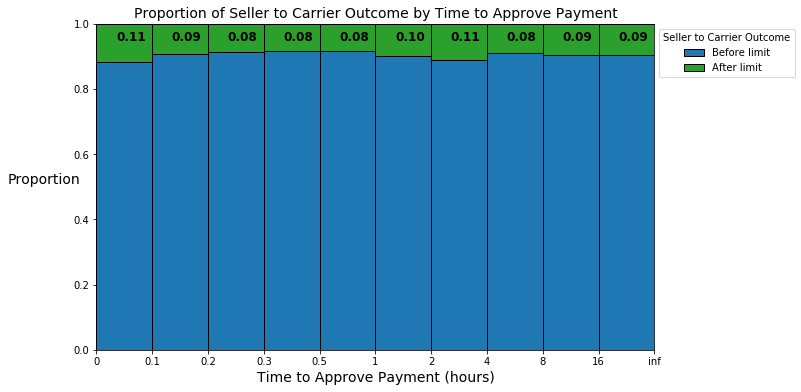

In [9]:
placement = [0,1,2,3,4,5,6,7,8,9]
xtick_placement = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
totals = list(df3.sum())

before_bars = [i / j for i, j in zip(df3.loc['Before limit',:], totals)]
after_bars = [i / j for i, j in zip(df3.loc['After limit',:], totals)]


bar_width = 1
legend_labels = ('Before limit','After limit')


plt.figure(figsize=(10,6))
# early bars
plt.bar(placement, before_bars, color='#1f77b4', edgecolor='black', width=bar_width)
# on time bars
plt.bar(placement, after_bars, bottom=before_bars, color='tab:green', edgecolor='black', width=bar_width)


# Custom x axis
plt.xticks(xtick_placement, bins)
plt.xlabel("Time to Approve Payment (hours)", fontsize=14)
plt.ylabel("Proportion", rotation=0, labelpad=30, fontsize=14)
plt.title('Proportion of Seller to Carrier Outcome by Time to Approve Payment', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Seller to Carrier Outcome', labels=legend_labels)
plt.xlim(-0.5,9.5)
plt.ylim(0,1)
# Show graphic

for i in range(len(before_bars)):
    plt.text(x=i-0.15,y=0.95,s=str(after_bars[i])[0:4], fontsize=12, fontweight='bold')
#    plt.text(x=i-0.15,y=0.94,s=str(after_limit_bars[i])[0:4], fontsize=12)


plt.savefig('images/time_payment_approval_stacked_spaced.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

In [10]:
# Repeat above but instead have 10 equal size bins
bin_labels = [1,2,3,4,5,6,7,8,9,10]
df2['binned_payment_approval_time_2'] = pd.qcut(df2['time_to_approve_payment'],10, labels=bin_labels)
df2

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,time_to_approve_payment,time_to_carrier,seller_to_carrier_limit,julianday(order_purchase_timestamp),seller_to_carrier_days_early,seller_to_carrier_outcome,time_to_deliver_full,shipment_outcome,binned_payment_approval_time,binned_payment_approval_time_2
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-19 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,0.775833,6.399468,6.032326,2.458010e+06,-0.367141,After limit,7.614421,Early delivery,5,7
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-03 11:05:13,2017-05-12 16:04:24,2017-05-15 00:00:00,0.201944,8.154097,7.008414,2.457870e+06,-1.145683,After limit,16.216181,Early delivery,3,3
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-18 14:48:30,2018-01-22 13:19:16,2018-02-05 00:00:00,0.249722,1.918947,4.010405,2.458133e+06,2.091458,Before limit,7.948437,Early delivery,3,4
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-15 10:10:18,2018-08-14 13:32:39,2018-08-20 00:00:00,0.161944,2.144039,7.006748,2.458339e+06,4.862708,Before limit,6.147269,Early delivery,2,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-02-13 13:57:51,2017-03-01 16:42:31,2017-03-17 00:00:00,0.206111,11.825208,9.000000,2.457789e+06,-2.825208,After limit,25.114352,Early delivery,3,3
5,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-23 03:55:27,2017-05-22 13:44:35,2017-06-06 00:00:00,30.214722,1.557882,7.258947,2.457889e+06,5.701065,Before limit,6.668067,Early delivery,10,9
6,00054e8431b9d7675808bcb819fb4a32,2017-12-10 11:53:48,2017-12-10 12:10:31,2017-12-12 01:07:48,2017-12-14 12:10:31,2017-12-18 22:03:38,2018-01-04 00:00:00,0.278611,1.551389,4.011609,2.458098e+06,2.460220,Before limit,8.423495,Early delivery,3,5
7,000576fe39319847cbb9d288c5617fa6,2018-07-04 12:08:27,2018-07-05 16:35:48,2018-07-05 12:15:00,2018-07-10 12:30:45,2018-07-09 14:04:07,2018-07-25 00:00:00,28.455833,1.004549,6.015486,2.458304e+06,5.010938,Before limit,5.080324,Early delivery,10,9
8,0005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-26 18:31:29,2018-03-29 18:17:31,2018-03-29 00:00:00,23.913333,8.248021,6.993704,2.458197e+06,-1.254317,After limit,9.984005,On time,10,9
9,0005f50442cb953dcd1d21e1fb923495,2018-07-02 13:59:39,2018-07-02 14:10:56,2018-07-03 14:25:00,2018-07-06 14:10:56,2018-07-04 17:28:31,2018-07-23 00:00:00,0.188056,1.017604,4.007836,2.458302e+06,2.990231,Before limit,2.145046,Early delivery,2,2


In [11]:
import re
# Need to determine what the bin ranges are for xtick labels
# Remove brackets w/ regex, split by comma, remove spaces, sort in order, use that for xtick labels.

bin_ranges = pd.qcut(df2['time_to_approve_payment'],10).unique()

bin_values = []
for i in list(bin_ranges):
    a = str(i)
    b = a.split(', ')
    #print(b)
    for j in b:
        c=re.sub('[\[\]\(\)]', '', j)
        d = float(c)
        if d not in bin_values:
            bin_values.append(d)

bin_values.sort()        
print(bin_values)

[-0.001, 0.168, 0.201, 0.231, 0.272, 0.343, 0.609, 5.832, 21.106, 34.588, 741.444, nan]


In [12]:
# #function to create: 10 columns (10 bins), 2 rows (before limit, after limit)

seller_carrier_outcomes = ['Before limit', 'After limit']
bin_labels = [1,2,3,4,5,6,7,8,9,10]



df4 = pd.DataFrame(data=None, index=seller_carrier_outcomes, columns=bin_labels)

for i in bin_labels:
    for j in seller_carrier_outcomes:
        df4.loc[j,i] = len(df2[(df2['seller_to_carrier_outcome']==j)&(df2['binned_payment_approval_time_2']==i)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df4

,1,2,3,4,5,6,7,8,9,10
Before limit,8481,8547,8475,8517,8522,8550,8424,8435,8491,8396
After limit,871,816,798,824,795,766,901,891,836,931


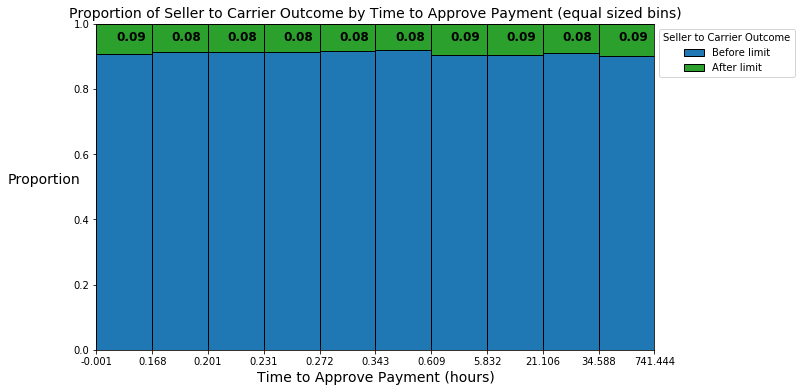

In [13]:
placement = [0,1,2,3,4,5,6,7,8,9]
xtick_placement = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
totals = list(df4.sum())

before_bars = [i / j for i, j in zip(df4.loc['Before limit',:], totals)]
after_bars = [i / j for i, j in zip(df4.loc['After limit',:], totals)]


bar_width = 1
legend_labels = ('Before limit','After limit')

plt.figure(figsize=(10,6))
# early bars
plt.bar(placement, before_bars, color='#1f77b4', edgecolor='black', width=bar_width)
# on time bars
plt.bar(placement, after_bars, bottom=before_bars, color='tab:green', edgecolor='black', width=bar_width)


# Custom x axis
plt.xticks(xtick_placement, bin_values[0:11])
plt.xlabel("Time to Approve Payment (hours)", fontsize=14)
plt.ylabel("Proportion", rotation=0, labelpad=30, fontsize=14)
plt.title('Proportion of Seller to Carrier Outcome by Time to Approve Payment (equal sized bins)', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Seller to Carrier Outcome', labels=legend_labels)
plt.xlim(-0.5,9.5)
plt.ylim(0,1)
# Show graphic

for i in range(len(before_bars)):
    plt.text(x=i-0.15,y=0.95,s=str(after_bars[i])[0:4], fontsize=12, fontweight='bold')
#    plt.text(x=i-0.15,y=0.94,s=str(after_limit_bars[i])[0:4], fontsize=12)


plt.savefig('images/time_payment_approval_stacked_size.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

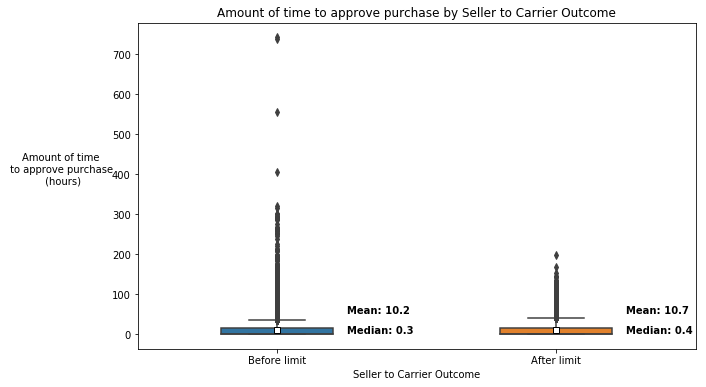

In [14]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

sns.boxplot(x='seller_to_carrier_outcome', y='time_to_approve_payment', data=df2, width=0.4, showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"}, order=['Before limit', 'After limit'], ax=ax1)
ax1.set_ylabel('Amount of time \n to approve purchase \n (hours)', rotation=0,labelpad=50)
ax1.set_xlabel('Seller to Carrier Outcome')
ax1.set_title('Amount of time to approve purchase by Seller to Carrier Outcome')

df_pa_al = df2[df2['seller_to_carrier_outcome']=='After limit']
df_pa_bl = df2[df2['seller_to_carrier_outcome']=='Before limit']

# Add mean labels to the box plot
mean_values = [df_pa_bl['time_to_approve_payment'].mean(), df_pa_al['time_to_approve_payment'].mean()]
mean_labels = [str(np.round(mv, 1)) for mv in mean_values]

# Add median labels to the box plot
median_values = [df_pa_bl['time_to_approve_payment'].median(), df_pa_al['time_to_approve_payment'].median()]
median_labels = [str(np.round(med_v, 1)) for med_v in median_values]


#pos = range(len(mean_values))

for tick in range(len(mean_values)):
# x_position, y_position, string_label, size, color, weight
    ax1.text(tick+0.25, median_values[tick] + 50, 'Mean: ' + mean_labels[tick], size=10, color='black', weight='semibold')
    ax1.text(tick+0.25, median_values[tick] + 0, 'Median: ' + median_labels[tick], size=10, color='black', weight='semibold')

#plt.savefig('images/time_approve_payment_box.JPG',bbox_inches='tight')
plt.savefig('images/payment_seller_carrier_box.JPG',bbox_inches='tight')
plt.show()

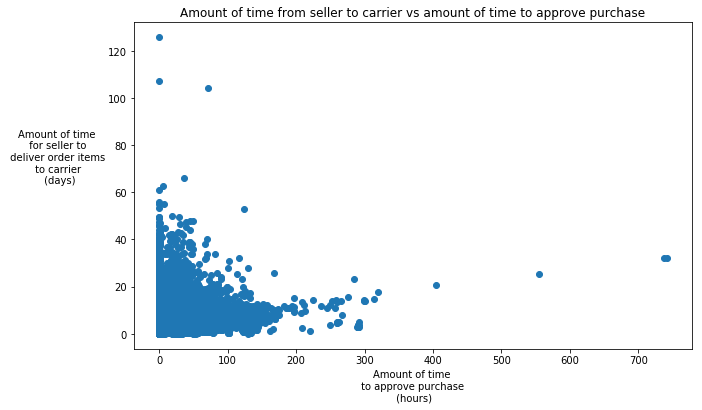

In [15]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

# Dataframes don't automatically update
#df_pa = run_query(q2)

ax1.scatter(x='time_to_approve_payment',y='time_to_carrier',data=df2)

#sns.boxplot(x='shipment_outcome', y='time_to_approve_payment', data=df_pa, width=0.4, showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"}, order=['Late delivery', 'On time', 'Early delivery'], ax=ax1)
#ax1.set(ylim=(-40,45))
ax1.set_ylabel('Amount of time \n for seller to \n deliver order items \n to carrier \n (days)', rotation=0,labelpad=50)
#ax1.set_xtick
ax1.set_xlabel('Amount of time \n to approve purchase \n (hours)')
#ax1.set(xlim=(-0.5,5))
ax1.set_title('Amount of time from seller to carrier vs amount of time to approve purchase')
plt.savefig('images/payment_carrier_scatter.JPG',bbox_inches='tight')
plt.show()

In [16]:
# Create feature 'payment_shipping_limit' with values 'Before' for when the payment is approved before the shipping limit and 'After' for when the payment is approved after the shipping limit.

df2.loc[df2['order_approved_at']<=df2['shipping_limit_date'],'payment_shipping_limit'] = 'Before'
df2.loc[df2['order_approved_at']>df2['shipping_limit_date'],'payment_shipping_limit'] = 'After'

df2[df2['payment_shipping_limit']=='After']

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,time_to_approve_payment,time_to_carrier,seller_to_carrier_limit,julianday(order_purchase_timestamp),seller_to_carrier_days_early,seller_to_carrier_outcome,time_to_deliver_full,shipment_outcome,binned_payment_approval_time,binned_payment_approval_time_2,payment_shipping_limit
61,002834535f7a609a5c68266f173fa59e,2018-07-23 17:26:00,2018-07-28 23:30:59,2018-07-24 15:53:00,2018-07-26 17:44:36,2018-08-11 01:48:33,2018-08-14 00:00:00,126.083056,0.935417,3.012917,2.458323e+06,2.077500,Before limit,18.348993,Early delivery,10,10,After
545,0184d4ddb259e1a4cfc2871888cf97b8,2017-09-01 20:04:28,2017-09-13 22:17:15,2017-09-04 14:05:50,2017-09-07 22:31:42,2017-09-09 15:12:44,2017-09-20 00:00:00,290.213056,2.750949,6.102245,2.457998e+06,3.351296,Before limit,7.797407,Early delivery,10,10,After
1388,03c8468d3001db38cadd59ac670341cc,2018-07-22 16:21:23,2018-07-27 23:31:15,2018-07-24 14:02:00,2018-07-26 04:25:19,2018-08-02 01:46:31,2018-08-07 00:00:00,127.164444,1.903206,3.502731,2.458322e+06,1.599525,Before limit,10.392454,Early delivery,10,10,After
1630,0467205a89711e4ec8e70ef2277e3287,2018-07-03 10:30:52,2018-07-05 16:40:30,2018-07-03 13:12:00,2018-07-05 11:31:12,2018-07-04 22:42:41,2018-07-16 00:00:00,54.160556,0.111898,2.041898,2.458303e+06,1.930000,Before limit,1.508206,Early delivery,10,10,After
1717,049fa9a29ba386943ccbd0954fe8b8a0,2018-07-03 08:35:57,2018-07-05 16:33:02,2018-07-03 17:14:00,2018-07-05 09:31:42,2018-07-09 19:28:54,2018-08-06 00:00:00,55.951389,0.359757,2.038715,2.458303e+06,1.678958,Before limit,6.453438,Early delivery,10,10,After
2552,06eb87385425e5797a1a5c2cdb1b6559,2017-09-01 18:53:08,2017-09-13 22:10:37,2017-09-06 21:10:11,2017-09-07 22:31:16,2017-09-15 18:53:50,2017-09-26 00:00:00,291.291389,5.095174,6.151481,2.457998e+06,1.056308,Before limit,14.000486,Early delivery,10,10,After
2884,07d395244b58ce72bbecdafbb1b60ace,2018-07-02 19:41:29,2018-07-05 16:26:51,2018-07-03 13:45:00,2018-07-05 04:30:58,2018-07-20 15:36:53,2018-07-25 00:00:00,68.756111,0.752442,2.367697,2.458302e+06,1.615255,Before limit,17.830139,Early delivery,10,10,After
3593,09b6daf7c780e789668ee3b7f4bda1c5,2018-06-29 18:20:57,2018-07-05 16:04:53,2018-07-03 13:08:00,2018-07-05 05:31:40,2018-07-09 10:48:30,2018-07-26 00:00:00,141.732222,3.782674,5.465775,2.458299e+06,1.683102,Before limit,9.685799,Early delivery,10,10,After
6273,1105262adc6ab25e5b789a33ea9e977b,2018-07-03 13:46:03,2018-07-05 16:20:54,2018-07-05 16:56:00,2018-07-05 14:31:53,2018-07-11 18:22:23,2018-07-20 00:00:00,50.580833,2.131910,2.031829,2.458303e+06,-0.100081,After limit,8.191898,Early delivery,10,10,After
7056,133d08a542c28f4400480b9483517c32,2018-07-21 22:54:08,2018-07-26 23:31:55,2018-07-23 11:47:00,2018-07-25 08:25:16,2018-08-07 14:45:31,2018-08-16 00:00:00,120.629722,1.536713,3.396620,2.458321e+06,1.859907,Before limit,16.660683,Early delivery,10,10,After


In [17]:
payment_outcomes = ['Before', 'After']
seller_carrier_outcomes = ['Before limit', 'After limit']

df5 = pd.DataFrame(data=None, index=seller_carrier_outcomes, columns=payment_outcomes)

for i in payment_outcomes:
    for j in seller_carrier_outcomes:
        df5.loc[j,i] = len(df2[(df2['payment_shipping_limit']==i)&(df2['seller_to_carrier_outcome']==j)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df5

,Before,After
Before limit,84749,97
After limit,8424,11


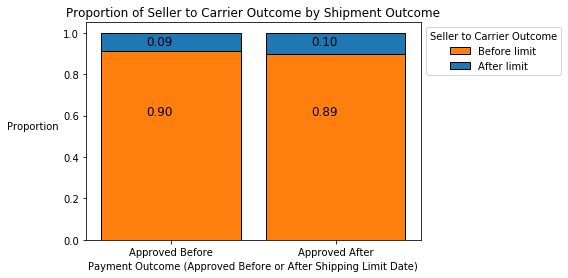

In [18]:
placement = [0, 1]
totals = list(df5.sum())
before_limit_bars = [i / j for i, j in zip(df5.loc['Before limit',:], totals)]
after_limit_bars = [i / j for i, j in zip(df5.loc['After limit',:], totals)]

bar_width = 0.85
labels = ('Approved Before', 'Approved After')
# before_limit bars
plt.bar(placement, before_limit_bars, color='tab:orange', edgecolor='black', width=bar_width)
# after_limit bars
plt.bar(placement, after_limit_bars, bottom=before_limit_bars, color='tab:blue', edgecolor='black', width=bar_width)
 
# Custom x axis
plt.xticks(placement, labels)
plt.xlabel("Payment Outcome (Approved Before or After Shipping Limit Date)")
plt.ylabel("Proportion", rotation=0, labelpad=30)
plt.title('Proportion of Seller to Carrier Outcome by Shipment Outcome')
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Seller to Carrier Outcome', labels=['Before limit', 'After limit'])
# Show graphic

for i in range(len(before_limit_bars)):
    plt.text(x=i-0.15,y=0.6,s=str(before_limit_bars[i])[0:4], fontsize=12)
    plt.text(x=i-0.15,y=0.94,s=str(after_limit_bars[i])[0:4], fontsize=12)
#ax1.text(x=2.5,y=800,s="Purchased:Available Ratio: 1.72", fontsize=12)
#ax1.text(x=3.5,y=2500,s="Purchased:Available Ratio: 1.59", fontsize=12)
#ax1.text(x=4.5,y=1200,s="Purchased:Available Ratio: 1.24", fontsize=12)
#ax1.text(x=5.35,y=800,s="Purchased:Available Ratio: 0.77", fontsize=12)
plt.savefig('images/payment_seller_to_carrier_stacked.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

In [19]:
# #function to create: 10 columns (10 bins), 3 rows (late, ontime, early)

ship_outcomes = ['Late delivery', 'On time', 'Early delivery']
bin_labels = [1,2,3,4,5,6,7,8,9,10]

df6 = pd.DataFrame(data=None, index=ship_outcomes, columns=bin_labels)

for i in bin_labels:
    for j in ship_outcomes:
        df6.loc[j,i] = len(df2[(df2['shipment_outcome']==j)&(df2['binned_payment_approval_time_2']==i)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df6

,1,2,3,4,5,6,7,8,9,10
Late delivery,539,558,559,580,657,624,758,609,749,779
On time,95,115,111,110,105,118,147,138,161,159
Early delivery,8715,8690,8602,8650,8553,8573,8420,8579,8417,8389


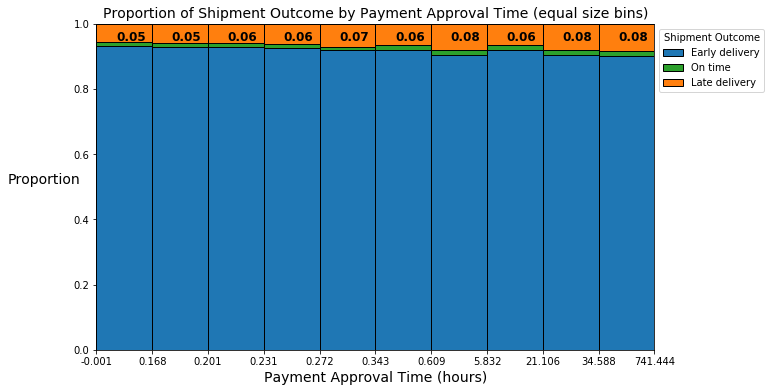

In [20]:
placement = [0,1,2,3,4,5,6,7,8,9]
xtick_placement = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
totals = list(df6.sum())

late_bars = [i / j for i, j in zip(df6.loc['Late delivery',:], totals)]
ontime_bars = [i / j for i, j in zip(df6.loc['On time',:], totals)]
early_bars = [i / j for i, j in zip(df6.loc['Early delivery',:], totals)]

#after_limit_bars = [i / j for i, j in zip(df3.loc['After limit',:], totals)]

bar_width = 1
legend_labels = ('Early delivery','On time','Late delivery')
#bins = [-10000, -20, -15,-10, -5,0,5,10,15,20,10000]

#xtick_labels = ['<-20', '-20 to-15', '-15 to -10', '-10 to -5','-5 to 0','0 to 5','5 to 10', '10 to 15', '15 to 20', '20+']
plt.figure(figsize=(10,6))
# early bars
plt.bar(placement, early_bars, color='#1f77b4', edgecolor='black', width=bar_width)
# on time bars
plt.bar(placement, ontime_bars, bottom=early_bars, color='tab:green', edgecolor='black', width=bar_width)
# late bars
plt.bar(placement, late_bars, bottom=[i+j for i,j in zip(early_bars, ontime_bars)], color='tab:orange', edgecolor='black', width=bar_width)


# Cqn use same bin_value labels from when we separated payment_approval_time into 10 equal size bins earlier
plt.xticks(xtick_placement, bin_values[:11])
plt.xlabel("Payment Approval Time (hours)", fontsize=14)
plt.ylabel("Proportion", rotation=0, labelpad=30, fontsize=14)
plt.title('Proportion of Shipment Outcome by Payment Approval Time (equal size bins)', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Shipment Outcome', labels=legend_labels)
plt.xlim(-0.5,9.5)
plt.ylim(0,1)
# Show graphic

for i in range(len(late_bars)):
    plt.text(x=i-0.15,y=0.95,s=str(late_bars[i])[0:4], fontsize=12, fontweight='bold')



plt.savefig('images/payment_shipment_outcome_stacked.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

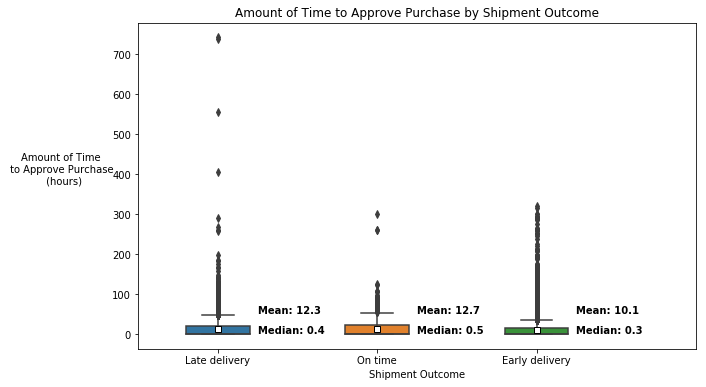

4


In [21]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

df_pa_late = df2[df2['shipment_outcome']=='Late delivery']
df_pa_ontime = df2[df2['shipment_outcome']=='On time']
df_pa_early = df2[df2['shipment_outcome']=='Early delivery']


#Zoom in
sns.boxplot(x='shipment_outcome', y='time_to_approve_payment', data=df2, width=0.4, showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"}, order=['Late delivery', 'On time', 'Early delivery'], ax=ax1)
ax1.set_ylabel('Amount of Time \n to Approve Purchase \n (hours)', rotation=0,labelpad=50)
ax1.set_xlabel('Shipment Outcome')
ax1.set_title('Amount of Time to Approve Purchase by Shipment Outcome')
ax1.set_xlim(-0.5,3.0)
# Add mean labels to the box plot
mean_values = [df_pa_late['time_to_approve_payment'].mean(), df_pa_ontime['time_to_approve_payment'].mean(), df_pa_early['time_to_approve_payment'].mean()]
mean_labels = [str(np.round(mv, 1)) for mv in mean_values]

# Add median labels to the box plot
median_values = [df_pa_late['time_to_approve_payment'].median(), df_pa_ontime['time_to_approve_payment'].median(), df_pa_early['time_to_approve_payment'].median()]
median_labels = [str(np.round(med_v, 1)) for med_v in median_values]


pos = range(len(mean_values))

for tick in range(len(mean_values)):
    # x_position, y_position, string_label, size, color, weight
    ax1.text(tick+0.25, median_values[tick] + 50, 'Mean: ' + mean_labels[tick], size=10, color='black', weight='semibold')
    ax1.text(tick+0.25, median_values[tick] + 0, 'Median: ' + median_labels[tick], size=10, color='black', weight='semibold')

plt.savefig('images/time_approve_payment_shipment_outcome_box.JPG', bbox_inches='tight', dpi=1200)
plt.show()
print(len(df2[df2['time_to_approve_payment']>350]))

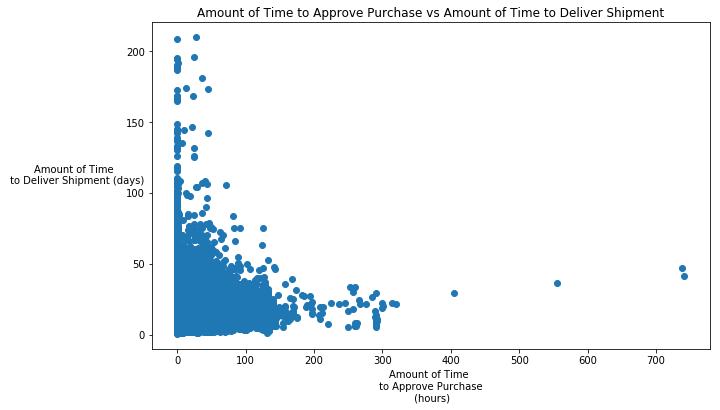

In [22]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

plt.scatter(x='time_to_approve_payment',y='time_to_deliver_full',data=df2)
plt.ylabel('Amount of Time \n to Deliver Shipment (days)', rotation=0,labelpad=50)
plt.xlabel('Amount of Time \n to Approve Purchase \n (hours)')
plt.title('Amount of Time to Approve Purchase vs Amount of Time to Deliver Shipment')

plt.savefig('images/time_approve_payment_shipment_outcome_scatter.JPG', bbox_inches='tight', dpi=1200)
plt.show()

In [23]:
payment_outcomes = ['Before', 'After']
shipment_outcomes = ['Early delivery', 'On time', 'Late delivery']

df7 = pd.DataFrame(data=None, index=shipment_outcomes, columns=payment_outcomes)

for i in payment_outcomes:
    for j in shipment_outcomes:
        df7.loc[j,i] = len(df2[(df2['payment_shipping_limit']==i)&(df2['shipment_outcome']==j)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df7

,Before,After
Early delivery,85500,102
On time,1257,2
Late delivery,6408,4


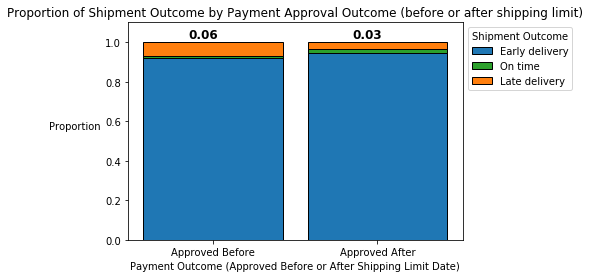

In [24]:
placement = [0, 1]
totals = list(df7.sum())

late_bars = [i / j for i, j in zip(df7.loc['Late delivery',:], totals)]
ontime_bars = [i / j for i, j in zip(df7.loc['On time',:], totals)]
early_bars = [i / j for i, j in zip(df7.loc['Early delivery',:], totals)]

legend_labels = ('Early delivery','On time','Late delivery')

bar_width = 0.85
labels = ('Approved Before', 'Approved After')
# early_bars
plt.bar(placement, early_bars, color='tab:blue', edgecolor='black', width=bar_width)
# ontime_bars
plt.bar(placement, ontime_bars, bottom=early_bars, color='tab:green', edgecolor='black', width=bar_width)
# late bars
plt.bar(placement, late_bars, bottom=[i+j for i,j in zip(early_bars, ontime_bars)], color='tab:orange', edgecolor='black', width=bar_width)
    
# Custom x axis
plt.xticks(placement, labels)
plt.xlabel("Payment Outcome (Approved Before or After Shipping Limit Date)")
plt.ylabel("Proportion", rotation=0, labelpad=30)
plt.title('Proportion of Shipment Outcome by Payment Approval Outcome (before or after shipping limit)')
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Shipment Outcome', labels=legend_labels)
plt.ylim(0,1.1)
# Show graphic

for i in range(len(late_bars)):
    plt.text(x=i-0.15,y=1.02,s=str(late_bars[i])[0:4], fontsize=12, fontweight='bold')

plt.savefig('images/payment_shipment_category_stacked.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

In [25]:
# Create feature 'payment_shipping_limit' with values 'Before' for when the payment is approved before the shipping limit and 'After' for when the payment is approved after the shipping limit.

df2.loc[df2['order_approved_at']<=df2['order_estimated_delivery_date'],'payment_expected_delivery'] = 'Before'
df2.loc[df2['order_approved_at']>df2['order_estimated_delivery_date'],'payment_expected_delivery'] = 'After'

df2[df2['payment_expected_delivery']=='After']

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,time_to_approve_payment,time_to_carrier,seller_to_carrier_limit,julianday(order_purchase_timestamp),seller_to_carrier_days_early,seller_to_carrier_outcome,time_to_deliver_full,shipment_outcome,binned_payment_approval_time,binned_payment_approval_time_2,payment_shipping_limit,payment_expected_delivery
20855,394d17c2b71a726e205caaeee3d2aa3d,2018-08-03 14:56:26,2018-08-08 23:31:22,2018-08-06 11:51:00,2018-08-07 15:10:09,2018-08-07 19:28:25,2018-08-08 00:00:00,128.582222,2.871227,4.009525,2.458334e+06,1.138299,Before limit,4.188877,Early delivery,10,10,After,After
24552,4387477eec4b3c89b39f3f454940d059,2018-08-09 20:45:10,2018-08-20 15:56:29,2018-08-14 12:35:00,2018-08-15 16:30:53,2018-08-15 14:56:43,2018-08-14 00:00:00,259.188611,4.659606,5.823414,2.458340e+06,1.163808,Before limit,5.758021,Late delivery,10,10,After,After
34357,5e981569f5835c96e4b288363b3b8f63,2018-07-30 16:25:37,2018-08-02 13:43:13,2018-07-31 13:42:00,2018-08-01 19:31:54,2018-08-01 15:17:54,2018-08-02 00:00:00,69.293333,0.886377,2.129363,2.458330e+06,1.242986,Before limit,1.952975,Early delivery,10,10,After,After
40003,6dcf0aeb8b1eb4021c26e1d0e9394979,2018-08-09 20:37:34,2018-08-20 15:59:18,2018-08-14 13:05:00,2018-08-15 16:31:14,2018-08-15 19:06:29,2018-08-15 00:00:00,259.362222,4.685718,5.828935,2.458340e+06,1.143218,Before limit,5.936748,On time,10,10,After,After
54496,9675440ebf61a1a3482cc6308e3ebd28,2018-08-18 23:35:23,2018-08-24 22:05:08,2018-08-27 16:14:00,2018-08-27 22:05:08,2018-08-28 17:37:30,2018-08-23 00:00:00,142.495833,8.693484,8.937326,2.458349e+06,0.243843,Before limit,9.751470,Late delivery,10,10,Before,After
84360,e73fe43cdcd166f7f0c6e3c2bf11a917,2018-08-09 18:06:43,2018-08-20 15:57:28,2018-08-14 14:48:00,2018-08-15 16:31:14,2018-08-15 15:46:38,2018-08-16 00:00:00,261.845833,4.862002,5.933692,2.458340e+06,1.071690,Before limit,5.902720,Early delivery,10,10,After,After


In [26]:
payment_outcomes = ['Before', 'After']
shipment_outcomes = ['Early delivery', 'On time', 'Late delivery']

df8 = pd.DataFrame(data=None, index=shipment_outcomes, columns=payment_outcomes)

for i in payment_outcomes:
    for j in shipment_outcomes:
        df8.loc[j,i] = len(df2[(df2['payment_expected_delivery']==i)&(df2['shipment_outcome']==j)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df8

,Before,After
Early delivery,85599,3
On time,1258,1
Late delivery,6410,2


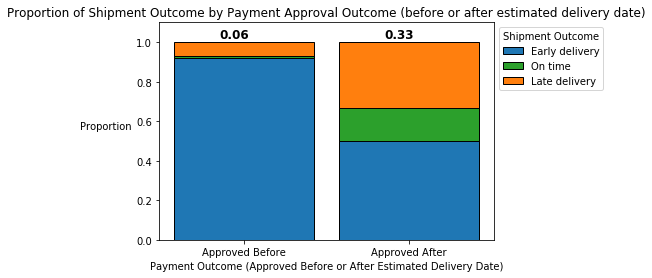

In [27]:
placement = [0, 1]
totals = list(df8.sum())

late_bars = [i / j for i, j in zip(df8.loc['Late delivery',:], totals)]
ontime_bars = [i / j for i, j in zip(df8.loc['On time',:], totals)]
early_bars = [i / j for i, j in zip(df8.loc['Early delivery',:], totals)]

legend_labels = ('Early delivery','On time','Late delivery')

bar_width = 0.85
labels = ('Approved Before', 'Approved After')
# early_bars
plt.bar(placement, early_bars, color='tab:blue', edgecolor='black', width=bar_width)
# ontime_bars
plt.bar(placement, ontime_bars, bottom=early_bars, color='tab:green', edgecolor='black', width=bar_width)
# late bars
plt.bar(placement, late_bars, bottom=[i+j for i,j in zip(early_bars, ontime_bars)], color='tab:orange', edgecolor='black', width=bar_width)
    
# Custom x axis
plt.xticks(placement, labels)
plt.xlabel("Payment Outcome (Approved Before or After Estimated Delivery Date)")
plt.ylabel("Proportion", rotation=0, labelpad=30)
plt.title('Proportion of Shipment Outcome by Payment Approval Outcome (before or after estimated delivery date)')
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Shipment Outcome', labels=legend_labels)
plt.ylim(0,1.1)
# Show graphic

for i in range(len(late_bars)):
    plt.text(x=i-0.15,y=1.02,s=str(late_bars[i])[0:4], fontsize=12, fontweight='bold')

plt.savefig('images/payment_shipment_category_stacked_2.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

### Seller

In [2]:
# Stacked histogram 

# Drop the 2 rows w/ null value for 'seller_to_carrier_days_early' (matplotlib's pyplot can't handle missing values)
df2_temp = df2.dropna(subset=['seller_to_carrier_days_early'])

# Into 3 separate arrays:
# seller_to_carrier_days_early values for late deliveries: 
x1 = list(df2_temp.loc[df2_temp['shipment_outcome']=='Late delivery', 'seller_to_carrier_days_early'])

# seller_to_carrier_days_early values for On time deliveries: 
x2 = list(df2_temp.loc[df2_temp['shipment_outcome']=='On time', 'seller_to_carrier_days_early'])

# seller_to_carrier_days_early values for On time deliveries: 
x3 = list(df2_temp.loc[df2_temp['shipment_outcome']=='Early delivery', 'seller_to_carrier_days_early'])

#Stack the data
plt.figure()
# Limit range from 15 days late to 15 days early
plt.hist([x3,x2,x1], color=['tab:blue', 'tab:green', 'tab:orange'], stacked=True, range=(-15,15), bins=10, edgecolor='black', linewidth=0.5)
plt.xlim(-15,15)

plt.title('Histogram of Seller to Carrier Days Early')
plt.xlabel('Number of Days Early: Seller to Carrier')
plt.ylabel('Count',rotation=0, labelpad=20)

plt.legend(title='Shipment Outcome', labels=legend_labels)

plt.savefig('images/seller_carrier_stacked_histogram.JPG',bbox_inches='tight', dpi=1200)
plt.show()


NameError: name 'df2' is not defined

Observations: This stacked histogram is hard to analyze b/c the sample size for the shipment outcomes varies so much (92% early, 7% late, 1% on time). Perhaps a stacked bar graph will be easier to look at.

In [29]:
# #function to create: 10 columns (10 bins), 3 rows (late, ontime, early)

ship_outcomes = ['Late delivery', 'On time', 'Early delivery']


bins = [-10000, -20, -15,-10, -5,0,5,10,15,20,10000]
bin_labels = [1,2,3,4,5,6,7,8,9,10]
df2['binned_seller_to_carrier'] = pd.cut(df2['seller_to_carrier_days_early'], bins=bins, labels=bin_labels)



df9 = pd.DataFrame(data=None, index=ship_outcomes, columns=bin_labels)

for i in bin_labels:
    for j in ship_outcomes:
        df9.loc[j,i] = len(df2[(df2['shipment_outcome']==j)&(df2['binned_seller_to_carrier']==i)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df9

,1,2,3,4,5,6,7,8,9,10
Late delivery,132,95,215,352,981,3592,1009,28,3,4
On time,3,6,19,51,220,786,171,2,1,0
Early delivery,27,29,80,603,5729,52800,24219,1605,303,207


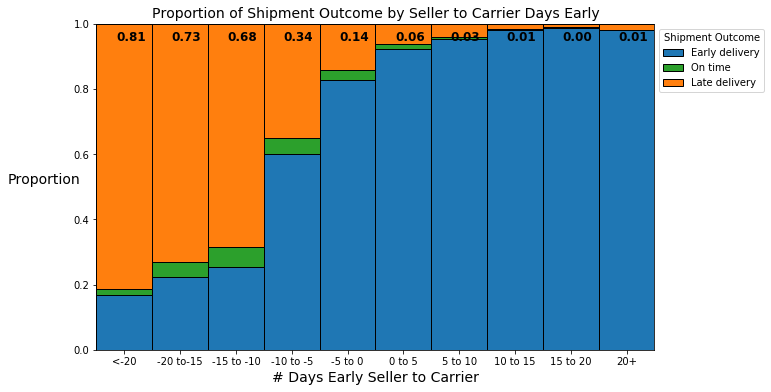

In [30]:
placement = [0,1,2,3,4,5,6,7,8,9]
totals = list(df9.sum())

late_bars = [i / j for i, j in zip(df9.loc['Late delivery',:], totals)]
ontime_bars = [i / j for i, j in zip(df9.loc['On time',:], totals)]
early_bars = [i / j for i, j in zip(df9.loc['Early delivery',:], totals)]

#after_limit_bars = [i / j for i, j in zip(df3.loc['After limit',:], totals)]

bar_width = 1
legend_labels = ('Early delivery','On time','Late delivery')
#bins = [-10000, -20, -15,-10, -5,0,5,10,15,20,10000]

xtick_labels = ['<-20', '-20 to-15', '-15 to -10', '-10 to -5','-5 to 0','0 to 5','5 to 10', '10 to 15', '15 to 20', '20+']
plt.figure(figsize=(10,6))
# early bars
plt.bar(placement, early_bars, color='#1f77b4', edgecolor='black', width=bar_width)
# on time bars
plt.bar(placement, ontime_bars, bottom=early_bars, color='tab:green', edgecolor='black', width=bar_width)
# late bars
plt.bar(placement, late_bars, bottom=[i+j for i,j in zip(early_bars, ontime_bars)], color='tab:orange', edgecolor='black', width=bar_width)


# Custom x axis
plt.xticks(placement, xtick_labels)
plt.xlabel("# Days Early Seller to Carrier", fontsize=14)
plt.ylabel("Proportion", rotation=0, labelpad=30, fontsize=14)
plt.title('Proportion of Shipment Outcome by Seller to Carrier Days Early', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Shipment Outcome', labels=legend_labels)
plt.xlim(-0.5,9.5)
plt.ylim(0,1)
# Show graphic

for i in range(len(late_bars)):
    plt.text(x=i-0.15,y=0.95,s=str(late_bars[i])[0:4], fontsize=12, fontweight='bold')
#    plt.text(x=i-0.15,y=0.94,s=str(after_limit_bars[i])[0:4], fontsize=12)


plt.savefig('images/seller_to_carrier_stacked_spaced.JPG',bbox_inches='tight', dpi=1200)
plt.show()

# Chi-square test for statistical analysis?

In [31]:
# Create 10 equal size bins
bin_labels = [1,2,3,4,5,6,7,8,9,10]
df2['binned_seller_to_carrier_2'] = pd.qcut(df2['seller_to_carrier_days_early'],10, labels=bin_labels)



# Extract the bin label ranges from the qcut() function
bin_ranges = pd.qcut(df2['seller_to_carrier_days_early'],10).unique()

bin_values = []
for i in list(bin_ranges):
    a = str(i)
    b = a.split(', ')
    #print(b)
    for j in b:
        c=re.sub('[\[\]\(\)]', '', j)
        d = round(float(c),2)
        if d not in bin_values:
            bin_values.append(d)

bin_values.sort()        
print(bin_values)

[-116.76, 0.11, 1.16, 1.96, 2.7, 3.23, 4.24, 4.98, 5.47, 6.45, 1046.86, nan]


In [32]:
shipment_outcomes = ['Early delivery', 'On time', 'Late delivery']
bin_labels = [1,2,3,4,5,6,7,8,9,10]

df10 = pd.DataFrame(data=None, index=shipment_outcomes, columns=bin_labels)

for i in bin_labels:
    for j in shipment_outcomes:
        df10.loc[j,i] = len(df2[(df2['shipment_outcome']==j)&(df2['binned_seller_to_carrier_2']==i)])
        


df10

,1,2,3,4,5,6,7,8,9,10
Early delivery,7161,8377,8592,8630,8738,8713,8665,8739,8923,9064
On time,318,215,145,99,105,108,90,86,61,32
Late delivery,1848,735,591,596,485,505,574,502,343,232


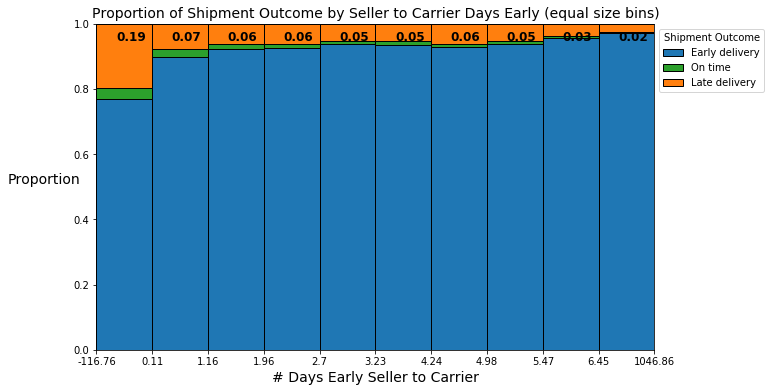

In [33]:
placement = [0,1,2,3,4,5,6,7,8,9]
totals = list(df10.sum())

late_bars = [i / j for i, j in zip(df10.loc['Late delivery',:], totals)]
ontime_bars = [i / j for i, j in zip(df10.loc['On time',:], totals)]
early_bars = [i / j for i, j in zip(df10.loc['Early delivery',:], totals)]


bar_width = 1
legend_labels = ('Early delivery','On time','Late delivery')


plt.figure(figsize=(10,6))
# early bars
plt.bar(placement, early_bars, color='#1f77b4', edgecolor='black', width=bar_width)
# on time bars
plt.bar(placement, ontime_bars, bottom=early_bars, color='tab:green', edgecolor='black', width=bar_width)
# late bars
plt.bar(placement, late_bars, bottom=[i+j for i,j in zip(early_bars, ontime_bars)], color='tab:orange', edgecolor='black', width=bar_width)


# Custom x axis
plt.xticks(xtick_placement, bin_values[0:11])
plt.xlabel("# Days Early Seller to Carrier", fontsize=14)
plt.ylabel("Proportion", rotation=0, labelpad=30, fontsize=14)
plt.title('Proportion of Shipment Outcome by Seller to Carrier Days Early (equal size bins)', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Shipment Outcome', labels=legend_labels)
plt.xlim(-0.5,9.5)
plt.ylim(0,1)

for i in range(len(before_bars)):
    plt.text(x=i-0.15,y=0.95,s=str(late_bars[i])[0:4], fontsize=12, fontweight='bold')



plt.savefig('images/seller_to_carrier_stacked_size.JPG',bbox_inches='tight', dpi=1200)
plt.show()

In [34]:
seller_carrier_outcomes = ['Before limit', 'After limit']
shipment_outcomes = ['Early delivery', 'On time', 'Late delivery']

df11 = pd.DataFrame(data=None, index=shipment_outcomes, columns=seller_carrier_outcomes)

for i in seller_carrier_outcomes:
    for j in shipment_outcomes:
        df11.loc[j,i] = len(df2[(df2['seller_to_carrier_outcome']==i)&(df2['shipment_outcome']==j)])
        

df11

,Before limit,After limit
Early delivery,79242,6360
On time,960,299
Late delivery,4637,1775


[84839, 8434]


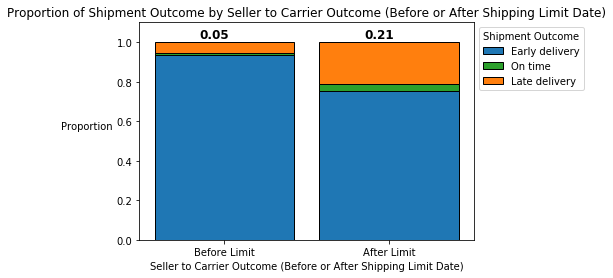

In [35]:
placement = [0, 1]
totals = list(df11.sum())

late_bars = [i / j for i, j in zip(df11.loc['Late delivery',:], totals)]
ontime_bars = [i / j for i, j in zip(df11.loc['On time',:], totals)]
early_bars = [i / j for i, j in zip(df11.loc['Early delivery',:], totals)]

legend_labels = ('Early delivery','On time','Late delivery')

bar_width = 0.85
labels = ('Before Limit', 'After Limit')
# early_bars
plt.bar(placement, early_bars, color='tab:blue', edgecolor='black', width=bar_width)
# ontime_bars
plt.bar(placement, ontime_bars, bottom=early_bars, color='tab:green', edgecolor='black', width=bar_width)
# late bars
plt.bar(placement, late_bars, bottom=[i+j for i,j in zip(early_bars, ontime_bars)], color='tab:orange', edgecolor='black', width=bar_width)
    
# Custom x axis
plt.xticks(placement, labels)
plt.xlabel("Seller to Carrier Outcome (Before or After Shipping Limit Date)")
plt.ylabel("Proportion", rotation=0, labelpad=30)
plt.title('Proportion of Shipment Outcome by Seller to Carrier Outcome (Before or After Shipping Limit Date)')
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Shipment Outcome', labels=legend_labels)
plt.ylim(0,1.1)
# Show graphic

for i in range(len(late_bars)):
    plt.text(x=i-0.15,y=1.02,s=str(late_bars[i])[0:4], fontsize=12, fontweight='bold')

plt.savefig('images/seller_carrier_category_stacked.JPG',bbox_inches='tight', dpi=1200)
print(totals)
plt.show()

In [36]:
ship_outcomes = ['Late delivery', 'On time', 'Early delivery']
seller_carrier_outcomes = ['Before limit', 'After limit']

df12 = pd.DataFrame(data=None, index=seller_carrier_outcomes, columns=ship_outcomes)

for i in ship_outcomes:
    for j in seller_carrier_outcomes:
        df12.loc[j,i] = len(df2[(df2['shipment_outcome']==i)&(df2['seller_to_carrier_outcome']==j)])
        

#function to create: 3 columns (late, ontime, early), 2 rows (before limit, after limit)
df12

,Late delivery,On time,Early delivery
Before limit,4637,960,79242
After limit,1775,299,6360


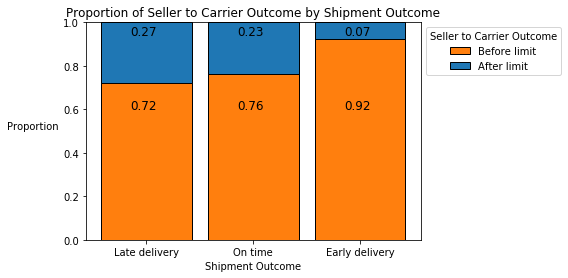

In [37]:
placement = [0, 1, 2]
totals = list(df12.sum())

before_limit_bars = [i / j for i, j in zip(df12.loc['Before limit',:], totals)]
after_limit_bars = [i / j for i, j in zip(df12.loc['After limit',:], totals)]

bar_width = 0.85
labels = ('Late delivery','On time','Early delivery')
# before_limit bars
plt.bar(placement, before_limit_bars, color='tab:orange', edgecolor='black', width=bar_width)
# after_limit bars
plt.bar(placement, after_limit_bars, bottom=before_limit_bars, color='tab:blue', edgecolor='black', width=bar_width)
 
# Custom x axis
plt.xticks(placement, labels)
plt.xlabel("Shipment Outcome")
plt.ylabel("Proportion", rotation=0, labelpad=30)
plt.title('Proportion of Seller to Carrier Outcome by Shipment Outcome')
plt.legend(bbox_to_anchor=(1,1), ncol=1,title='Seller to Carrier Outcome', labels=['Before limit', 'After limit'])
plt.ylim(0,1)
# Show graphic

for i in range(len(before_limit_bars)):
    plt.text(x=i-0.15,y=0.6,s=str(before_limit_bars[i])[0:4], fontsize=12)
    plt.text(x=i-0.15,y=0.94,s=str(after_limit_bars[i])[0:4], fontsize=12)

plt.savefig('images/seller_carrier_category_stacked_flipped.JPG',bbox_inches='tight', dpi=1200)
plt.show()